In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    average_precision_score, confusion_matrix,
    f1_score
)
from numpy.linalg import norm
from scipy.stats import zscore
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import sem
from collections import defaultdict
import warnings
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [6]:
def generate_patient_graphs(EHR_binary, EHR_continuous, labels):
    X_bin = EHR_binary.values
    X_cont = EHR_continuous.values
    num_patients, num_bin = X_bin.shape
    _, num_cont = X_cont.shape
    total_nodes = num_bin + num_cont

    # --- Node features ---
    # Binary: Bernoulli means
    bin_event_probs = np.mean(X_bin, axis=0)
    # Continuous: Z-score normalization
    X_cont_z = zscore(X_cont, axis=0, ddof=0)  # shape: (num_patients, num_cont)

    # --- Edge features (dependency/correlation matrix) ---
    edge_weights = np.zeros((total_nodes, total_nodes))

    # Combine all features column-wise
    all_features = np.concatenate([X_bin, X_cont_z], axis=1)

    edge_weights = np.zeros((total_nodes, total_nodes))
    cosine_sims = []

    # First pass: compute all edge weights
    for i in range(total_nodes):
        for j in range(total_nodes):
            if i == j:
                continue
            xi = all_features[:, i]
            xj = all_features[:, j]

            if i < num_bin and j < num_bin:
                # binary-binary: conditional P(xi=1 | xj=1)
                numerator = np.sum((xi == 1) & (xj == 1))
                denominator = np.sum(xj == 1)
                edge_weights[i, j] = numerator / denominator if denominator != 0 else 0.0
            else:
                # Store raw cosine similarity to normalize later
                cos_sim = np.dot(xi, xj) / (norm(xi) * norm(xj) + 1e-8)
                cosine_sims.append((i, j, cos_sim))

    # Normalize cosine similarities to [0, 1]
    cos_vals = [val for _, _, val in cosine_sims]
    cos_min = min(cos_vals)
    cos_max = max(cos_vals)
    for i, j, raw_cos in cosine_sims:
        normalized_cos = (raw_cos - cos_min) / (cos_max - cos_min + 1e-8)
        edge_weights[i, j] = normalized_cos



    # --- Construct per-patient graphs ---
    patient_graphs = []
    for idx in range(num_patients):
        bin_feats = np.where(X_bin[idx] == 1, bin_event_probs, 1 - bin_event_probs)
        cont_feats = X_cont_z[idx]  # already normalized
        node_features = np.concatenate([bin_feats, cont_feats])
        node_features = torch.tensor(node_features, dtype=torch.float32).unsqueeze(1)

        # Edge index (fully connected, directed)
        edge_index = torch.tensor(
            [[i, j] for i in range(total_nodes) for j in range(total_nodes) if i != j],
            dtype=torch.long
        ).t().contiguous()

        # Edge attributes
        edge_attr = torch.tensor(
            [edge_weights[i, j] for i in range(total_nodes) for j in range(total_nodes) if i != j],
            dtype=torch.float32
        ).unsqueeze(1)

        label_tensor = torch.tensor(labels[idx], dtype=torch.float32)

        patient_graphs.append((node_features, edge_index, edge_attr, label_tensor))

    return patient_graphs



class EGraphSageLayer(nn.Module):
    def __init__(self, in_dim_node, in_dim_edge, out_dim, num_negatives=5, lr=1e-3):
        super().__init__()
        self.message_linear = nn.Linear(in_dim_node + in_dim_edge, out_dim)
        self.update_linear = nn.Linear(in_dim_node + out_dim, out_dim)

        # Larger weight initialization for final layer
        nn.init.xavier_uniform_(self.update_linear.weight, gain=2.0)
        nn.init.constant_(self.update_linear.bias, 0.0)

        self.num_negatives = num_negatives
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, node_feats, edge_index, edge_feats):
        # node_feats.requires_grad_(True)
        num_nodes = node_feats.size(0)
        src, dst = edge_index[0], edge_index[1]

        dst_feats = node_feats[dst]
        edge_feats_input = edge_feats[src]                    # (num_edges, node_dim)
        
        # edge_feats = edge_feats[src]  # Match source node count (num_edges)

        edge_inputs = torch.cat([dst_feats, edge_feats_input], dim=1)
        messages = F.leaky_relu(self.message_linear(edge_inputs), negative_slope=0.1) # (num_edges, 256)

        agg = torch.zeros(num_nodes, messages.size(1), device=node_feats.device)
        agg.index_add_(0, src, messages)

        deg = torch.bincount(src, minlength=num_nodes).unsqueeze(1).clamp(min=1)
        agg = agg / deg

        node_inputs = torch.cat([node_feats, agg], dim=1)         # (num_nodes, node_dim + 256)
        updated_nodes = F.leaky_relu(self.update_linear(node_inputs), negative_slope=0.1)         # (num_nodes, 256)

        return updated_nodes


class EGraphSageNet(nn.Module):
    def __init__(self, num_layers, hidden_dim=32, lr=1e-2, num_negatives=5):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(EGraphSageLayer(1, 1, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(EGraphSageLayer(hidden_dim, 1, hidden_dim))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.num_negatives = num_negatives
        self.classifier = nn.Linear(hidden_dim, 3)

    def compute_hybrid_loss(self, patient_embeddings, label_vec, lambda_cov=0.001):
        """
        Combines supervised CrossEntropy loss with covariance penalty.
        """
        device = patient_embeddings.device
        graph_embedding = patient_embeddings.mean(dim=0)  # [hidden_dim]

        # Step 2: Classify
        logits = self.classifier(graph_embedding.unsqueeze(0))  # [1, 3]

        # Step 3: Prepare target
        label_tensor = torch.tensor([int(label_vec.item())], dtype=torch.long, device=logits.device)

        # Step 4: Cross-Entropy Loss
        ce_loss = F.cross_entropy(logits, label_tensor)


        # Covariance Penalty
        z_centered = patient_embeddings - patient_embeddings.mean(dim=0, keepdim=True)
        cov = (z_centered.T @ z_centered) / (z_centered.size(0) - 1)
        identity = torch.eye(cov.size(0)).to(device)
        cov_penalty = torch.norm(cov - identity, p='fro')

        total_loss = ce_loss + lambda_cov * cov_penalty

        self._debug_last_losses = (ce_loss.item(), cov_penalty.item())

        return total_loss


    def forward(self, node_feats, edge_index, edge_feats):
        for layer in self.layers:
            node_feats = layer(node_feats, edge_index, edge_feats)
        return node_feats
    
    def compute_unsupervised_loss(self, node_embeddings, edge_index):
        pos_loss = 0.0
        neg_loss = 0.0
        num_edges = edge_index.size(1)
        device = node_embeddings.device
        eps = 1e-8

        norms = torch.norm(node_embeddings, dim=1, keepdim=True) + eps
        normed_embeddings = node_embeddings / norms

        for idx in range(num_edges):
            src = edge_index[0, idx]
            dst = edge_index[1, idx]
            z_i = normed_embeddings[src]
            z_j = normed_embeddings[dst]

            dot_pos = torch.dot(z_i, z_j)
            pos_loss += -torch.log(torch.sigmoid(dot_pos) + eps)

            all_sims = torch.matmul(normed_embeddings, z_i)
            all_sims[src] = 1.0
            all_sims[dst] = 1.0
            _, hard_neg_indices = torch.topk(-all_sims, self.num_negatives)

            for neg_idx in hard_neg_indices:
                z_k = normed_embeddings[neg_idx]
                dot_neg = torch.dot(z_i, z_k)
                neg_loss += -torch.log(torch.sigmoid(-dot_neg) + eps)

        total_loss = (pos_loss + neg_loss) / (num_edges + eps)
        return total_loss


class EGraphSageClassifier(nn.Module):
    def __init__(self, num_layers=3, hidden_dim=32, num_outputs=3, num_events=None):
        super().__init__()
        self.gnn = EGraphSageNet(num_layers=num_layers, hidden_dim=hidden_dim)
        # self.output_layer = nn.Linear(hidden_dim * num_events, num_outputs)
        self.output_layer = nn.Linear(hidden_dim, num_outputs)

    def forward(self, node_feats, edge_index, edge_feats, return_embedding=False):
        node_embeddings = self.gnn(node_feats, edge_index, edge_feats)  # shape: (M, hidden_dim)
        # z_Gi = node_embeddings.flatten()  # shape: (M * hidden_dim,)
        z_Gi = node_embeddings.mean(dim=0)

        logits = self.gnn.classifier(z_Gi.unsqueeze(0)).squeeze(0)  # use trained classifier
        probs = F.softmax(logits, dim=0)

        if return_embedding:
            return probs, z_Gi  # Return both
        else:
            return probs  # Standard use

# Convert the list of graph data to a Dataset-compatible structure
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graph_list):
        self.graph_list = graph_list

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, idx):
        return self.graph_list[idx]

# Collate function to batch graphs (assumes one graph per sample)
def collate_fn(batch):
    return batch  # keep it simple for now since batching full graphs may not be supported

# === Load Data ===
print("Loading data...")
df = pd.read_pickle("df_encoded_files/df_encoded_final_with_outcome.pkl")
df = df.drop(columns=["ID"])
X = df.drop(columns=["Dropout Status"])
y = df["Dropout Status"]
y_encoded = LabelEncoder().fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

binary_cols = [col for col in X.columns if set(X[col].dropna().unique()).issubset({0, 1})]
continuous_cols = [col for col in X.columns if col not in binary_cols]

# X_binary = X[binary_cols]
# X_continuous = X[continuous_cols]

X_train_binary = X_train[binary_cols]
X_train_cont = X_train[continuous_cols]
X_test_binary = X_test[binary_cols]
X_test_cont = X_test[continuous_cols]

# === Apply SMOTE to training data ===
X_train_combined = pd.concat([X_train_binary, X_train_cont], axis=1)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)



X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42
)

X_train_binary_resampled = X_train_split[binary_cols]
X_train_cont_resampled = X_train_split[continuous_cols]
X_val_binary = X_val_split[binary_cols]
X_val_cont = X_val_split[continuous_cols]


train_graphs_with_labels = generate_patient_graphs(
    X_train_binary_resampled, X_train_cont_resampled, y_train_split
)
val_graphs_with_labels = generate_patient_graphs(
    X_val_binary, X_val_cont, y_val_split
)
test_graphs_with_labels = generate_patient_graphs(
    X_test_binary, X_test_cont, y_test
)


all_classes = np.array([0, 1, 2])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Repeated 5-Fold CV ===
gnn_scores_all = []

accuracy_scores = []
recall_scores = []
precision_scores = []
specificity_scores = []

num_events = X.shape[1]
# Generate patient graphs
# train_graphs_with_labels = generate_patient_graphs(X_binary, X_continuous, y_encoded)

# dataset = GraphDataset(train_graphs_with_labels)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataset = GraphDataset(train_graphs_with_labels)
val_dataset = GraphDataset(val_graphs_with_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


model = EGraphSageClassifier(num_layers=3, hidden_dim=32, num_outputs=3, num_events=num_events).to(device)
model.train()
optimizer = model.gnn.optimizer
num_epochs = 500

print(f"Using device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")

best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


for epoch in range(num_epochs):
    total_loss = 0.0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()
        batch_loss = 0.0
        for node_feats, edge_index, edge_feats, label_vec in batch:
            node_feats = node_feats.to(device)
            edge_index = edge_index.to(device)
            edge_feats = edge_feats.to(device)
            node_embeddings = model.gnn(node_feats, edge_index, edge_feats)
            loss = model.gnn.compute_hybrid_loss(node_embeddings, label_vec)
            batch_loss += loss
            
            ce_loss, cov_penalty = model.gnn._debug_last_losses  # store them in model during compute

        # print(f"CE Loss: {ce_loss:.4f}, Cov Penalty: {cov_penalty:.4f}") 

        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()

    # === Compute validation loss ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            for node_feats, edge_index, edge_feats, label_vec in batch:
                node_feats = node_feats.to(device)
                edge_index = edge_index.to(device)
                edge_feats = edge_feats.to(device)
                node_embeddings = model.gnn(node_feats, edge_index, edge_feats)
                loss = model.gnn.compute_hybrid_loss(node_embeddings, label_vec)
                val_loss += loss.item()

    val_loss /= len(val_dataloader)

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")

    # === Check for improvement ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")  # Save best model
    else:
        epochs_without_improvement += 1

    # === Step the LR scheduler ===
    scheduler.step(val_loss)

    # === Early stopping condition ===
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # for batch in tqdm(dataloader, desc="Training"):
    #     optimizer.zero_grad()  # ✅ Clear previous gradients before new step

    #     batch_loss = 0.0
    #     for node_feats, edge_index, edge_feats, label_vec in batch:
    #         node_feats = node_feats.to(device)
    #         edge_index = edge_index.to(device)
    #         edge_feats = edge_feats.to(device)

    #         node_embeddings = model.gnn(node_feats, edge_index, edge_feats)
    #         loss = model.gnn.compute_unsupervised_loss(node_embeddings, edge_index)
    #         batch_loss += loss

    #     batch_loss.backward()
    #     optimizer.step()
    #     total_loss += batch_loss.item()

    # print(f"Epoch {epoch + 1} Training Loss: {total_loss:.4f}")

# === Embedding Extraction ===
def extract_embeddings_and_predictions(model, graph_list):
    model.eval()
    embeddings = []
    probs_all = []
    preds = []
    labels = []

    with torch.no_grad():
        for node_feats, edge_index, edge_feats, label_vec in graph_list:
            node_feats = node_feats.to(device)
            edge_index = edge_index.to(device)
            edge_feats = edge_feats.to(device)
            label_vec = label_vec.to(device)

            probs, embedding = model(node_feats, edge_index, edge_feats, return_embedding=True)
            pred_class = torch.argmax(probs).item()

            embeddings.append(embedding.cpu().numpy())
            probs_all.append(probs.cpu().numpy())
            preds.append(pred_class)
            labels.append(label_vec.cpu().item())

    X_embeds = np.vstack(embeddings)
    y_labels = np.array(labels)
    y_preds = np.array(preds)
    y_probs = np.vstack(probs_all)

    return X_embeds, y_labels, y_preds, y_probs

# === Train Set ===
X_train_embeds, y_train_labels, y_train_preds, y_train_probs = extract_embeddings_and_predictions(model, train_graphs_with_labels)
np.save("saved_embeddings/X_train_embeddings.npy", X_train_embeds)
np.save("saved_embeddings/y_train_labels.npy", y_train_labels)

# === Validation Set ===
X_val_embeds, y_val_labels, y_val_preds, y_val_probs = extract_embeddings_and_predictions(model, val_graphs_with_labels)
np.save("saved_embeddings/X_val_embeddings.npy", X_val_embeds)
np.save("saved_embeddings/y_val_labels.npy", y_val_labels)


# === Test Set ===
X_test_embeds, y_test_labels, y_test_preds, y_test_probs = extract_embeddings_and_predictions(model, test_graphs_with_labels)
np.save("saved_embeddings/X_test_embeddings.npy", X_test_embeds)
np.save("saved_embeddings/y_test_labels.npy", y_test_labels)

# === Evaluation on Test Set ===
print("\nEvaluation on Test Set:")
acc = accuracy_score(y_test_labels, y_test_preds)
f1 = f1_score(y_test_labels, y_test_preds, average='macro')
roc_auc = roc_auc_score(y_test_labels, y_test_probs, multi_class='ovr')
pr_auc = average_precision_score(y_test_labels, y_test_probs, average='macro')
cm = confusion_matrix(y_test_labels, y_test_preds)

print(f"Accuracy       : {acc:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"ROC AUC        : {roc_auc:.4f}")
print(f"AUC-PR         : {pr_auc:.4f}")
print(f"Confusion Matrix:\n{cm}")

Loading data...
Using device: cuda
CUDA Available: True

Epoch 1/500


Training:  19%|█▉        | 60/320 [00:04<00:20, 12.62it/s]


KeyboardInterrupt: 

In [21]:
import numpy as np

# Load the data
X_train = np.load("saved_embeddings/X_train_embeddings.npy")

# Compute variance for each feature (column)
variances = np.var(X_train, axis=0)

# Calculate min, max, and count of low-variance features
min_var = np.min(variances)
max_var = np.max(variances)
num_low_var = np.sum(variances < 0.01)

# Print results
print(f"Minimum variance: {min_var}")
print(f"Maximum variance: {max_var}")
print(f"Number of features with variance < 0.01: {num_low_var}")


Minimum variance: 0.0012309300946071744
Maximum variance: 6.2326250076293945
Number of features with variance < 0.01: 15


In [48]:
# === Load saved data ===
# X_train = np.load("saved_embeddings/X_train_embeddings.npy")
# y_train = np.load("saved_embeddings/y_train_labels.npy")

X_train = np.load("saved_embeddings/X_train_embeddings.npy")
y_train = np.load("saved_embeddings/y_train_labels.npy")
X_tune = np.load("saved_embeddings/X_val_embeddings.npy")
y_tune = np.load("saved_embeddings/y_val_labels.npy")
X_test = np.load("saved_embeddings/X_test_embeddings.npy")
y_test = np.load("saved_embeddings/y_test_labels.npy")

# === Split training into tuning + validation ===
# X_tune, X_val, y_tune, y_val = train_test_split(
#     X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
# )

# === Base Models ===
base_models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    )
}

# === Hyperparameter Grids ===
param_grids = {
    "XGBoost": {
        'learning_rate': [0.01, 0.05],
        'max_depth': [5, 7],
        'n_estimators': [100, 200],
        'subsample': [0.6, 0.8]
    },
    "Random Forest": {
        'n_estimators': [200, 300, 400],
        'max_depth': [5, 7],
        'max_features': [0.8, 0.95]
    }
}

# === Grid Search ===
best_params = {}
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='f1_macro',
        verbose=1,
        n_jobs=1
    )
    grid.fit(X_tune, y_tune)
    best_params[model_name] = grid.best_params_
    print(f"  Best Params: {grid.best_params_}")

# === Final Models ===
final_models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        **best_params["XGBoost"]
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        **best_params["Random Forest"]
    )
}

for model_name, base_model in base_models.items():
    print(f"\n=== Two-Stage Classification: {model_name} ===")

    # === Stage 1: Predict 0 vs not 0 ===
    y_train_stage1 = np.where(y_train == 0, 0, 1)

    model_stage1 = base_model.set_params(**best_params[model_name])
    model_stage1.fit(X_train, y_train_stage1)
    y_pred_stage1 = model_stage1.predict(X_test)
    y_proba_stage1 = model_stage1.predict_proba(X_test)

    # === Evaluate Stage 1: Binary classification (0 vs not-0) ===
    y_test_stage1 = np.where(y_test == 0, 0, 1)

    acc1 = accuracy_score(y_test_stage1, y_pred_stage1)
    f1_1 = f1_score(y_test_stage1, y_pred_stage1, average='binary')
    roc_auc1 = roc_auc_score(y_test_stage1, y_proba_stage1[:, 1])
    pr_auc1 = average_precision_score(y_test_stage1, y_proba_stage1[:, 1])
    cm1 = confusion_matrix(y_test_stage1, y_pred_stage1)

    print(f"--- Stage 1 Results (0 vs not-0) ---")
    print(f"  Accuracy       : {acc1:.4f}")
    print(f"  F1 Score       : {f1_1:.4f}")
    print(f"  ROC AUC        : {roc_auc1:.4f}")
    print(f"  AUC-PR         : {pr_auc1:.4f}")
    print(f"  Confusion Matrix:\n{cm1}")


    # === Stage 2: Predict 1 vs 2 for predicted non-0 ===
    stage2_mask_train = y_train != 0
    stage2_mask_test = y_pred_stage1 != 0

    # Reinitialize model for Stage 2
    if model_name == "XGBoost":
        model_stage2 = XGBClassifier(
            use_label_encoder=False,
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=42,
            **best_params["XGBoost"]
        )
    else:
        model_stage2 = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            **best_params["Random Forest"]
        )

    # Re-label: class 1 → 0, class 2 → 1 for binary classification
    y_train_stage2 = np.where(y_train[stage2_mask_train] == 1, 0, 1)
    model_stage2.fit(X_train[stage2_mask_train], y_train_stage2)

    # Stage 2 predictions
    y_pred_stage2_raw = model_stage2.predict(X_test[stage2_mask_test])
    y_pred_stage2 = np.where(y_pred_stage2_raw == 0, 1, 2)
    y_pred_final = np.copy(y_pred_stage1)
    y_pred_final[stage2_mask_test] = y_pred_stage2

    # === Construct 3-class probability matrix ===
    y_proba_final = np.zeros((X_test.shape[0], 3))

    

    # Fill stage 1 class 0 probabilities
    y_proba_final[:, 0] = y_proba_stage1[:, 0]

    # For samples predicted as not class 0:
    # Assign class 1 and 2 probabilities from stage 2 model
    y_proba_stage2 = model_stage2.predict_proba(X_test[stage2_mask_test])
    # class 1 = stage2 class 0, class 2 = stage2 class 1
    y_proba_final[stage2_mask_test, 1] = y_proba_stage1[stage2_mask_test, 1] * y_proba_stage2[:, 0]
    y_proba_final[stage2_mask_test, 2] = y_proba_stage1[stage2_mask_test, 1] * y_proba_stage2[:, 1]

    # Normalize rows to sum to 1
    y_proba_final /= y_proba_final.sum(axis=1, keepdims=True)


    # === Final 3-class metrics ===
    acc = accuracy_score(y_test, y_pred_final)
    f1 = f1_score(y_test, y_pred_final, average='macro')
    roc_auc = roc_auc_score(y_test, y_proba_final, multi_class='ovr')
    pr_auc = average_precision_score(y_test, y_proba_final, average='macro')
    cm = confusion_matrix(y_test, y_pred_final)

    print(f"  Accuracy       : {acc:.4f}")
    print(f"  F1 Score       : {f1:.4f}")
    print(f"  ROC AUC        : {roc_auc:.4f}")
    print(f"  AUC-PR         : {pr_auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}")



Tuning XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
  Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  Best Params: {'max_depth': 5, 'max_features': 0.8, 'n_estimators': 200}

=== Two-Stage Classification: XGBoost ===
--- Stage 1 Results (0 vs not-0) ---
  Accuracy       : 0.5336
  F1 Score       : 0.4096
  ROC AUC        : 0.5322
  AUC-PR         : 0.4514
  Confusion Matrix:
[[177  90]
 [132  77]]
  Accuracy       : 0.4433
  F1 Score       : 0.3057
  ROC AUC        : 0.5048
  AUC-PR         : 0.3314
  Confusion Matrix:
[[177  19  71]
 [ 54   4  28]
 [ 78  15  30]]

=== Two-Stage Classification: Random Forest ===
--- Stage 1 Results (0 vs not-0) ---
  Accuracy       : 0.5567
  F1 Score       : 0.1977
  ROC AUC        : 0.5281
  AUC-PR         : 0.4550
  Confusion Matrix:
[[239  28]
 [183  26]]
  Accuracy       : 0.5231
  F1 Score  

In [20]:
from collections import Counter
import numpy as np

# Print distribution using Counter
print("Distribution of y_train_resampled (after SMOTE):")
print(Counter(y_train))

print("\nDistribution of y_test (original test set):")
print(Counter(y_test))

# Optionally, print percentages
def print_percentages(y, name):
    total = len(y)
    counter = Counter(y)
    print(f"\n{name} class percentages:")
    for cls, count in counter.items():
        print(f"Class {cls}: {count} ({count / total:.2%})")

print_percentages(y_train_resampled, "y_train_resampled")
print_percentages(y_test, "y_test")


Distribution of y_train_resampled (after SMOTE):
Counter({np.float64(2.0): 1065, np.float64(0.0): 1065, np.float64(1.0): 1065})

Distribution of y_test (original test set):
Counter({np.float64(0.0): 267, np.float64(2.0): 123, np.float64(1.0): 86})

y_train_resampled class percentages:
Class 2: 1065 (33.33%)
Class 0: 1065 (33.33%)
Class 1: 1065 (33.33%)

y_test class percentages:
Class 0.0: 267 (56.09%)
Class 2.0: 123 (25.84%)
Class 1.0: 86 (18.07%)


In [28]:
########Code that doesn't have RFE for Random Forest

# Suppress warnings
warnings.filterwarnings("ignore")

# === Load Embeddings and Labels ===
X_embeddings = np.load("saved_embeddings/X_embeddings.npy", allow_pickle=True)
y_labels = np.load("saved_embeddings/y_labels.npy", allow_pickle=True)

# Convert to proper format
X = np.vstack(X_embeddings).astype(np.float32)
y = np.array(y_labels)

# === Base Models for GridSearch ===
from sklearn.feature_selection import RFE

# === Base Models for GridSearch ===
base_models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced'   # ✅ Added here
    )
}


# === Train/Validation Split ===
X_tune, X_holdout, y_tune, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Hyperparameter Grids ===
param_grids = {
    "XGBoost": {
        'learning_rate': [0.01, 0.05],
        'max_depth': [5, 7],
        'n_estimators': [100, 200],
        'subsample': [0.6, 0.8]
    },
    "Random Forest": {
        'n_estimators': [200, 300, 400],
        'max_depth': [5, 7],
        'max_features': [0.8, 0.95]
    }
}

# === Grid Search for Best Parameters ===
best_params = {}
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='f1_macro',
        verbose=0,
        n_jobs=4  
    )
    grid.fit(X_tune, y_tune)
    best_params[model_name] = grid.best_params_
    print(f"  Best Params: {grid.best_params_}")

# === Final Models with Best Params ===
models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        **best_params["XGBoost"]
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        **best_params["Random Forest"]
    )
}



# === Evaluation Function ===
def compute_metrics(y_true, y_prob, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    try:
        if y_prob.shape[1] == 2:
            auc_roc = roc_auc_score(y_true, y_prob[:, 1])
            auc_pr = average_precision_score(y_true, y_prob[:, 1])
        else:
            auc_roc = roc_auc_score(y_true, y_prob, multi_class="ovo", average='macro')
            auc_pr = average_precision_score(y_true, y_prob, average='macro')
    except:
        auc_roc, auc_pr = np.nan, np.nan
    return acc, f1, auc_roc, auc_pr

# === Cross-Validation ===
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
results = {model_name: defaultdict(list) for model_name in models}

all_y_true = {model_name: [] for model_name in models}
all_y_pred = {model_name: [] for model_name in models}


for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    for train_idx, test_idx in rskf.split(X_holdout, y_holdout):
        X_train, X_test = X_holdout[train_idx], X_holdout[test_idx]
        y_train, y_test = y_holdout[train_idx], y_holdout[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true[model_name].extend(y_test)
        all_y_pred[model_name].extend(y_pred)


        n_classes = len(np.unique(y_train))
        y_prob = (
            model.predict_proba(X_test)
            if hasattr(model, "predict_proba")
            else np.eye(n_classes)[y_pred]
        )

        acc, f1, auc_roc, auc_pr = compute_metrics(y_test, y_prob, y_pred)
        results[model_name]['Accuracy'].append(acc)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['AUC-ROC'].append(auc_roc)
        results[model_name]['AUC-PR'].append(auc_pr)

# === Print Results ===
print("\nCross-Validated Performance (5x5-fold)")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, scores in metrics.items():
        mean_score = np.nanmean(scores)
        stderr = sem(scores, nan_policy='omit')
        print(f"  {metric_name}: {mean_score:.4f} ± {stderr:.4f}")

print("\nConfusion Matrices")
for model_name in models:
    print(f"\n{model_name} Confusion Matrix:")
    cm = confusion_matrix(all_y_true[model_name], all_y_pred[model_name])
    print(cm)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_embeddings/X_embeddings.npy'

In [ ]:
###Code that has RFE for Random Forest

# Suppress warnings
warnings.filterwarnings("ignore")

# === Load Embeddings and Labels ===
X_embeddings = np.load("saved_embeddings/X_embeddings.npy", allow_pickle=True)
y_labels = np.load("saved_embeddings/y_labels.npy", allow_pickle=True)

# Convert to proper format
X = np.vstack(X_embeddings).astype(np.float32)
y = np.array(y_labels)

# === Base Models for GridSearch ===
from sklearn.feature_selection import RFE

# === Base Models for GridSearch ===
base_models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced'   # ✅ Added here
    )
}


# === Train/Validation Split ===
X_tune, X_holdout, y_tune, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Hyperparameter Grids ===
param_grids = {
    "XGBoost": {
        'learning_rate': [0.01, 0.05],
        'max_depth': [5, 7],
        'n_estimators': [100, 200],
        'subsample': [0.6, 0.8]
    },
    "Random Forest": {
        'n_estimators': [200, 300, 400],
        'max_depth': [5, 7],
        'max_features': [0.8, 0.95]
    }
}

# === Grid Search for Best Parameters ===
best_params = {}
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='f1_macro',
        verbose=0,
        n_jobs=-1
    )
    grid.fit(X_tune, y_tune)
    best_params[model_name] = grid.best_params_
    print(f"  Best Params: {grid.best_params_}")

# === Final Models with Best Params ===
# === Final Models with Best Params ===
models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        **best_params["XGBoost"]
    ),
    "Random Forest": RFE(  # ✅ Wrap RandomForest with RFE
        estimator=RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            **best_params["Random Forest"]
        ),
        n_features_to_select=40  # ✅ Select top 40 features (or change as needed)
    )
}


# === Evaluation Function ===
def compute_metrics(y_true, y_prob, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    try:
        if y_prob.shape[1] == 2:
            auc_roc = roc_auc_score(y_true, y_prob[:, 1])
            auc_pr = average_precision_score(y_true, y_prob[:, 1])
        else:
            auc_roc = roc_auc_score(y_true, y_prob, multi_class="ovo", average='macro')
            auc_pr = average_precision_score(y_true, y_prob, average='macro')
    except:
        auc_roc, auc_pr = np.nan, np.nan
    return acc, f1, auc_roc, auc_pr

# === Cross-Validation ===
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
results = {model_name: defaultdict(list) for model_name in models}

all_y_true = {model_name: [] for model_name in models}
all_y_pred = {model_name: [] for model_name in models}


for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    for train_idx, test_idx in rskf.split(X_holdout, y_holdout):
        X_train, X_test = X_holdout[train_idx], X_holdout[test_idx]
        y_train, y_test = y_holdout[train_idx], y_holdout[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true[model_name].extend(y_test)
        all_y_pred[model_name].extend(y_pred)


        n_classes = len(np.unique(y_train))
        y_prob = (
            model.predict_proba(X_test)
            if hasattr(model, "predict_proba")
            else np.eye(n_classes)[y_pred]
        )

        acc, f1, auc_roc, auc_pr = compute_metrics(y_test, y_prob, y_pred)
        results[model_name]['Accuracy'].append(acc)
        results[model_name]['F1 Score'].append(f1)
        results[model_name]['AUC-ROC'].append(auc_roc)
        results[model_name]['AUC-PR'].append(auc_pr)

# === Print Results ===
print("\nCross-Validated Performance (5x5-fold)")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, scores in metrics.items():
        mean_score = np.nanmean(scores)
        stderr = sem(scores, nan_policy='omit')
        print(f"  {metric_name}: {mean_score:.4f} ± {stderr:.4f}")

print("\nConfusion Matrices")
for model_name in models:
    print(f"\n{model_name} Confusion Matrix:")
    cm = confusion_matrix(all_y_true[model_name], all_y_pred[model_name])
    print(cm)

In [8]:
import numpy as np

# Load embeddings and labels
X_embeddings = np.load("saved_embeddings/X_embeddings.npy")
y_labels = np.load("saved_embeddings/y_labels.npy")

# Calculate min and max of embeddings
X_min = X_embeddings.min()
X_max = X_embeddings.max()
print(f"Min of X_embeddings: {X_min}")
print(f"Max of X_embeddings: {X_max}")

# Calculate variance of each feature
variances = np.var(X_embeddings, axis=0)

# Count number of features with variance below 0.01
low_variance_count = np.sum(variances < 0.01)
print(f"Number of features with variance below 0.01: {low_variance_count}")

num_features = X_embeddings.shape[1]
print(f"Number of features: {num_features}")

import numpy as np

num_zeros = np.sum(X_embeddings == 0)
total_elements = X_embeddings.size
percent_zeros = (num_zeros / total_elements) * 100

print(f"Number of zeros: {num_zeros}")
print(f"Total elements: {total_elements}")
print(f"Percentage of zeros: {percent_zeros:.2f}%")


Min of X_embeddings: -0.2504233717918396
Max of X_embeddings: 3.1098434925079346
Number of features with variance below 0.01: 23
Number of features: 32
Number of zeros: 0
Total elements: 76160
Percentage of zeros: 0.00%


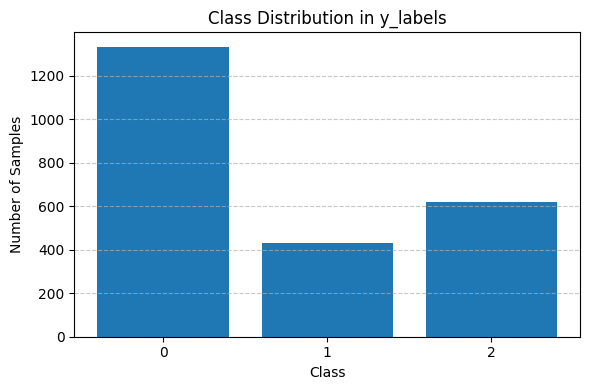

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load labels
y_labels = np.load("saved_embeddings/y_labels.npy")

# Count class frequencies
class_counts = Counter(y_labels)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in y_labels")
plt.xticks(sorted(class_counts.keys()))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
